In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
#from google.colab.patches import cv2_imshow
import re
from bs4 import BeautifulSoup #for reading xml file
import matplotlib.pyplot as plt
#from wordcloud import WordCloud, STOPWORDS  #for plotting wordcloud
#from tqdm import tqdm

# **Exploratory Data Analysis**

## **Images**

In [5]:
image_folder = 'image/test' #path to folder containing images
total_images = len(os.listdir(image_folder))
print('The number of images in data are: %i'%(total_images))

The number of images in data are: 7471


In [6]:
#showing random 3 sample images
np.random.seed(420)
for i in range(3):
    k = np.random.choice(range(total_images))
    image_file = os.listdir(image_folder)[k]
    image = cv2.imread(os.path.join(image_folder,image_file)) #getting an image file
    print("%i)\n"%(i+1))
    #cv2.imshow('',image)
    print("\t\t",image_file) #the image file name

1)

		 CXR2449_IM-0984-1001.png
2)

		 CXR3518_IM-1717-1001.png
3)

		 CXR3187_IM-1503-2001.png


In [7]:
reports_folder = "image/ecgen-radiology"
total_reports = len(os.listdir(reports_folder))
print('The number of reports in the data are: %i'%(total_reports))

The number of reports in the data are: 3955


In [8]:
no_images = [] #stores the no. of images
for file in os.listdir(reports_folder):
  report_file = os.path.join(reports_folder,file)
  with open(report_file, 'r') as f:  #reading the xml data
    data = f.read()
  regex = r"parentImage id.*" #getting all the image names
  k  = re.findall(regex,data)
  temp = len(k)
  no_images.append(temp)

In [9]:
no_images = np.array(no_images)
print("The max no. of images found associated with a report: %i"%(no_images.max()))
print("The min no. of images found associated with a report: %i"%(no_images.min()))

The max no. of images found associated with a report: 5
The min no. of images found associated with a report: 0


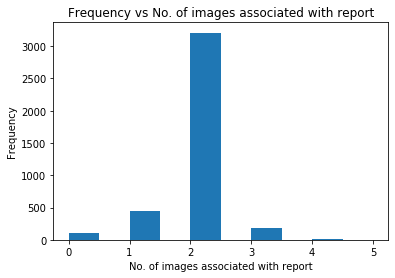

Image Value_counts

2    3208
1     446
3     181
0     104
4      15
5       1
dtype: int64


In [7]:
plt.figure(figsize = (6,4))
ax = pd.Series(no_images).plot(kind='hist')
ax.set_xlabel('No. of images associated with report')
ax.set_title("Frequency vs No. of images associated with report")
plt.show()
print("Image Value_counts\n")
print(pd.Series(no_images).value_counts())

In [10]:
# function for obtaining the different information part of the xml report file and preprocessing them and also adding the concernced image and report information to the dataframe
def decontracted(phrase): #https://stackoverflow.com/a/47091490
  """
  performs text decontraction of words like won't to will not
  """
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


def get_info(xml_data,info): #https://regex101.com/
  """
  extracts the information data from the xml file and does text preprocessing on them
  here info can be 1 value in this list ["COMPARISON","INDICATION","FINDINGS","IMPRESSION"]
  """
  regex = r"\""  +info +r"\".*" 
  k = re.findall(regex,xml_data)[0] #finding info part of the report

  regex = r"\>.*\<"
  k = re.findall(regex,k)[0] #removing info string and /AbstractText>'

  regex = r"\d." 
  k = re.sub(regex,"",k) #removing all values like "1." and "2." etc

  regex = r"X+"
  k = re.sub(regex,"",k) #removing words like XXXX

  regex = r" \."
  k = re.sub(regex,"",k) #removing singular fullstop ie " ."

  regex = r"[^.a-zA-Z]" 
  k = re.sub(regex," ",k) #removing all special characters except for full stop

  regex = r"\."
  k = re.sub(regex," .",k) #adding space before fullstop
  k = decontracted(k) #perform decontraction
  k = k.strip().lower() #strips the begining and end of the string of spaces and converts all into lowercase
  k = " ".join(k.split()) #removes unwanted spaces
  if k=="": #if the resulting sentence is an empty string return null value
    k = np.nan
  return k

def get_final(data):
  """
  given an xml data returns "COMPARISON","INDICATION","FINDINGS","IMPRESSION" part of the data
  """
  try: #assigning null values to the ones that don't have the concerned info
      comparison = get_info(data, "COMPARISON")
  except:
    comparison = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    indication = get_info(data, "INDICATION")
  except:
    indication = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    finding = get_info(data,"FINDINGS")
  except:
    finding = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    impression = get_info(data, "IMPRESSION")
  except:
    impression = np.nan;

  return comparison,indication,finding,impression

def get_df():
  """
  Given an xml data, it will extract the two image names and corresponding info text and returns a dataframe
  """
  im1 = [] #there are 2 images associated with a report
  im2 = []
  #stores info
  comparisons = []
  indications = []
  findings = []
  impressions = [] 
  report = [] #stores xml file name
  for file in tqdm(os.listdir(reports_folder)):
    report_file = os.path.join(reports_folder,file)
    with open(report_file, 'r') as f:  #reading the xml data
      data = f.read()
  
    regex = r"parentImage id.*" #getting all the image names
    k  = re.findall(regex,data)

    if len(k)==2: 
      regex = r"\".*\"" #getting the name
      image1 = re.findall(regex,k[0])[0]
      image2 = re.findall(regex,k[1])[0]

      image1 = re.sub(r"\"","",image1)
      image2 = re.sub(r"\"","",image2)

      image1 = image1.strip()+".png"
      image2 = image2.strip()+".png"
      im1.append(image1)
      im2.append(image2)

      comparison,indication,finding,impression = get_final(data)
      comparisons.append(comparison)
      indications.append(indication)
      findings.append(finding)
      impressions.append(impression)
      report.append(file) #xml file name

    
    elif len(k)<2:
      regex = r"\".*\"" #getting the name
      try: #if the exception is raised means no image file name was found
        image1 = re.findall(regex,k[0])[0]
        image1 = re.sub(r"\"","",image1) #removing "
        image2 = np.nan

        image1 = image1.strip()+".png"
      except:
        image1 = np.nan
        image2 = np.nan


      im1.append(image1)
      im2.append(image2)
      comparison,indication,finding,impression = get_final(data)
      comparisons.append(comparison)
      indications.append(indication)
      findings.append(finding)
      impressions.append(impression)
      report.append(file) #xml file name
    
    else: #if there are more than 2 images concerned with report
      comparison,indication,finding,impression = get_final(data)

      for i in range(len(k)-1):
        regex = r"\".*\"" #getting the name
        image1 = re.findall(regex,k[i])[0] #re.findall returns a list
        image2 = re.findall(regex,k[i+1])[0] 

        image1 = re.sub(r"\"","",image1) #removing "
        image2 = re.sub(r"\"","",image2) #removing "

        image1 = image1.strip()+".png"
        image2 = image2.strip()+".png"

        im1.append(image1)
        im2.append(image2)
        comparisons.append(comparison)
        indications.append(indication)
        findings.append(finding)
        impressions.append(impression)
        report.append(file) #xml file name
    
  df = pd.DataFrame({"image_1":im1,"image_2":im2,"comparison":comparisons,"indication":indications,"findings":findings,"impression":impressions,"xml file name":report})
  return df

In [9]:
%%time
df = get_df()

100%|████████████████████████████████████████████████████████████████████████████| 3955/3955 [00:00<00:00, 5658.09it/s]


Wall time: 722 ms


In [10]:
df.to_pickle("df.pkl")

In [11]:
# df.to_pickle("/content/drive/My Drive/Medical image Reporting/df.pkl")
df = pd.read_pickle("df.pkl")
df.shape

(4169, 7)

In [12]:
df.head()

,image_1,image_2,comparison,indication,findings,impression,xml file name
0,CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png,none .,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x .,1.xml
1,CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png,chest radiographs,year old male chest pain .,the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process .,10.xml
2,CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png,none .,NaN,both lungs are clear and expanded . heart and ...,no active disease .,100.xml
3,CXR1000_IM-0003-1001.png,CXR1000_IM-0003-2001.png,pa and lateral chest radiographs,year old male,there is increased opacity within the right up...,increased opacity in the right upper lobe with...,1000.xml
4,CXR1000_IM-0003-2001.png,CXR1000_IM-0003-3001.png,pa and lateral chest radiographs,year old male,there is increased opacity within the right up...,increased opacity in the right upper lobe with...,1000.xml


In [13]:
print("columns\t\t%missing values")
print('-'*30)
print(df.isnull().sum()*100/df.shape[0] )#percentage missing values

columns		%missing values
------------------------------
image_1           2.494603
image_2          13.192612
comparison       33.605181
indication        6.308467
findings         13.504438
impression        0.839530
xml file name     0.000000
dtype: float64


In [14]:
df.drop(df[(df['impression'].isnull())|(df['image_1'].isnull())].index,inplace=True)
df = df.reset_index(drop=True).copy()
print("%i datapoints were removed.\nFinal no. of datapoints: %i"%(4169-df.shape[0],df.shape[0]))

136 datapoints were removed.
Final no. of datapoints: 4033


In [15]:
%%time
df.loc[df.image_2.isnull(),'image_2'] = df[df.image_2.isnull()]['image_1'].values
im1_size = []
im2_size = []
for index,row in df.iterrows():
  im1_size.append( cv2.imread(os.path.join(image_folder,row.get('image_1'))).shape[:2])
  im2_size.append(cv2.imread(os.path.join(image_folder,row.get('image_2'))).shape[:2])

Wall time: 26.4 s


In [16]:
df['im1_height'] = [i[0] for i in im1_size]
df['im1_width'] = [i[1] for i in im1_size]
df['im2_height'] = [i[0] for i in im2_size]
df['im2_width'] = [i[1] for i in im2_size]

In [17]:
df.head(2)

,image_1,image_2,comparison,indication,findings,impression,xml file name,im1_height,im1_width,im2_height,im2_width
0,CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png,none .,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x .,1.xml,624,512,420,512
1,CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png,chest radiographs,year old male chest pain .,the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process .,10.xml,624,512,420,512


In [18]:
df.to_pickle("df_final.pkl")
df = pd.read_pickle("df_final.pkl")
df.shape

(4033, 11)

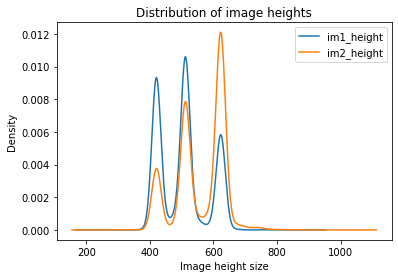



Value Counts of image_1 heights:

420    1130
512     926
624     674
511     234
618      87
Name: im1_height, dtype: int64

 ************************************************** 

Value Counts of image_2 heights:

624    1455
512     714
420     453
511     218
618      89
Name: im2_height, dtype: int64


In [19]:
ax = df[['im1_height','im2_height']].plot(kind='kde')
ax.set_title("Distribution of image heights")
ax.set_xlabel("Image height size")
plt.show()

print("\n\nValue Counts of image_1 heights:\n")
print(df.im1_height.value_counts()[:5])
print("\n","*"*50,"\n")
print("Value Counts of image_2 heights:\n")
print(df.im2_height.value_counts()[:5])

In [20]:
print("Value Counts of image_1 widths:\n")
print(df.im1_width.value_counts()[:5])
print("\n","*"*50,"\n")
print("Value Counts of image_2 widths:\n")
print(df.im2_width.value_counts()[:5])

Value Counts of image_1 widths:

512    4033
Name: im1_width, dtype: int64

 ************************************************** 

Value Counts of image_2 widths:

512    4033
Name: im2_width, dtype: int64


## **Sample Images + Caption**

In [21]:
def show_image_captions(df = df,image_folder = image_folder,sample = 3):
  """
  given the df, samples datapoints and prints the images and caption
  df: dataframe
  image_folder: folder which contains images
  """
  k = df.sample(sample)
  i=1
  for index,row in k.iterrows():
    image_1 = cv2.imread(os.path.join(image_folder,row.get('image_1')))
    image_2 = cv2.imread(os.path.join(image_folder,row.get('image_2')))

    plt.figure(figsize = (12,8)) #setting the figure size
    plt.subplot(121) #first x-ray
    plt.imshow(image_1,aspect='auto')

    plt.subplot(122) #2nd x-ray
    plt.imshow(image_2, aspect = 'auto')
    print("%i)\n"%(i))
    i+=1
    plt.show() #printing the image
    print("\n","Comparison: ",row.get('comparison'))
    print("\n","Indication: ",row.get('indication'))
    print("\n","Findings: ",row.get('findings'))
    print("\n","Impression: ",row.get('impression'),"\n\n","*"*150,"\n\n")

1)



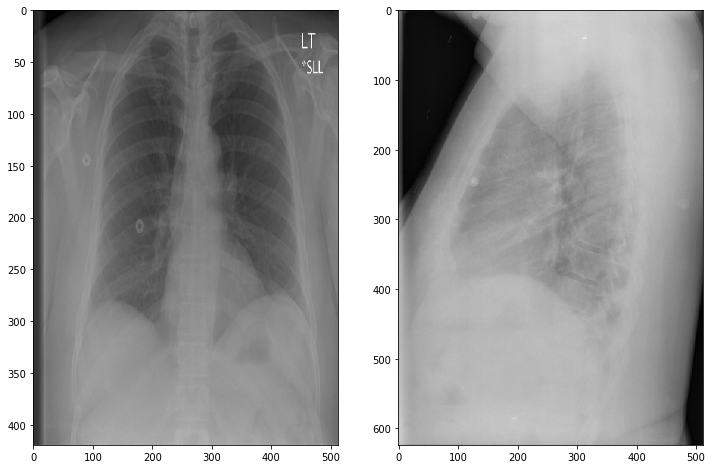


 Comparison:  none available .

 Indication:  year old chest pain .

 Findings:  normal heart . clear lungs . no pneumothorax . no pleural effusion . trachea is midline .

 Impression:  normal chest exam . 

 ****************************************************************************************************************************************************** 


2)



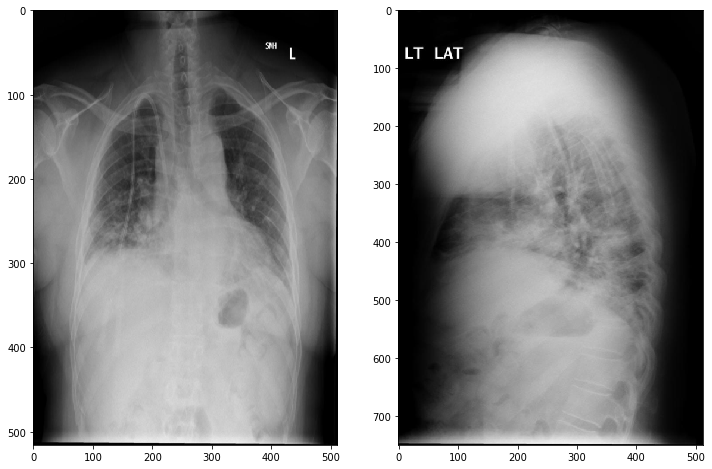


 Comparison:  none .

 Indication:  year old male shortness of breath . reported history of sarcoid .

 Findings:  right dual lumen internal jugular central venous catheter seen with tip overlying the cavoatrial junction . heart size at the upper limits of normal . low lung volumes with bronchovascular crowding . patchy bibasilar air airspace opacities right greater than left . no visualized pneumothorax . prominence of the mediastinum consistent with history of sarcoid .

 Impression:  bilateral lower lung airspace disease right greater than left most representing acute infectious process . widening of the mediastinum secondary to lymphadenopathy related to sarcoid or possibly reactive adenopathy . 

 ****************************************************************************************************************************************************** 


3)



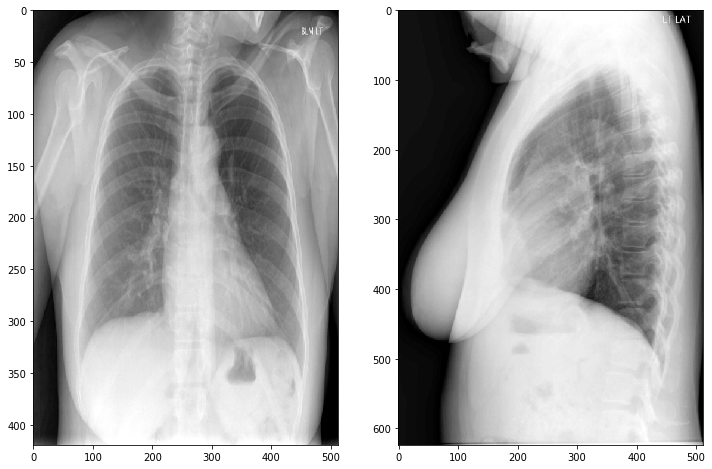


 Comparison:  none .

 Indication:  year old female with

 Findings:  cardiac silhouette is upper limits of normal in size . normal mediastinal contour and pulmonary vasculature . there is evidence of healed granulomatous disease in the right hemithorax . lungs are without focal airspace consolidation large pleural effusion or pneumothorax .

 Impression:  no acute cardiopulmonary findings . 

 ****************************************************************************************************************************************************** 




In [22]:
#showing sample 3 datapoints
show_image_captions()

### **Wordcloud of Impressions**

In [23]:
temp = df.loc[:,'impression'].str.replace(".","").copy() #removing all fullstops and storing the result in a temp variable
words = ""
for i in temp.values:
  k = i.split()
  words+= " ".join(k) + " "
word = words.strip()
wc = WordCloud(width = 1024, height = 720, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 15,).generate(words) 

del k,words,temp

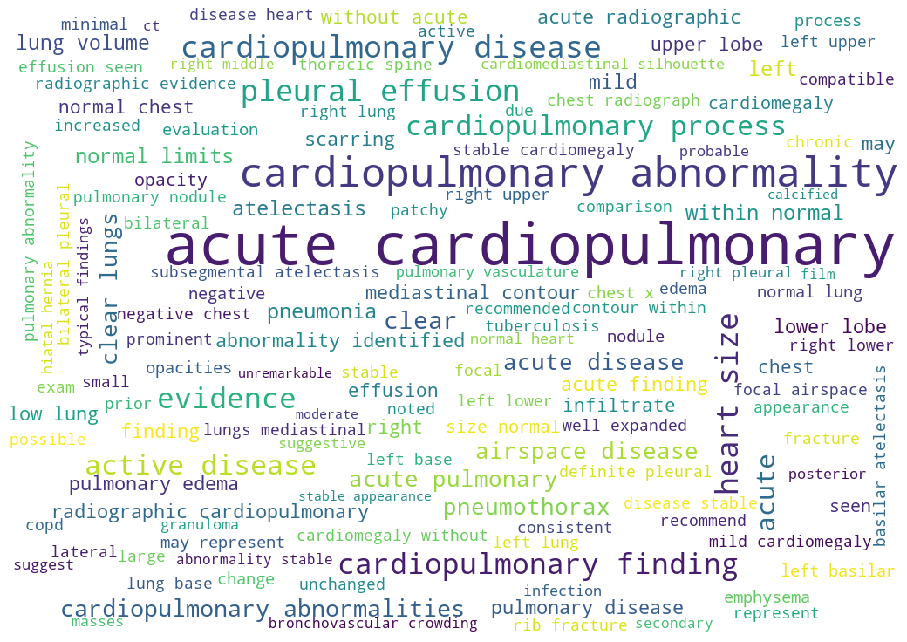

In [24]:
plt.figure(figsize = (16,16))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [25]:
#image_folder = '/content/drive/My Drive/Medical image Reporting/Images'
df_path = 'df_final.pkl'
chexnet_weights = 'chexnet_weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

In [26]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="false" #https://github.com/tensorflow/tensorflow/issues/33721#issuecomment-577307175

In [27]:
df = pd.read_pickle(df_path)
col = ['image_1','image_2','impression','xml file name']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = '<CLS> ' + df.impression + ' <END>'
df['impression_ip'] = '<CLS> ' + df.impression
df['impression_op'] = df.impression + ' <END>' 
print(df.shape)
df.head(2)

(4033, 7)


,image_1,image_2,impression,xml file name,impression_final,impression_ip,impression_op
0,image/test\CXR1_1_IM-0001-3001.png,image/test\CXR1_1_IM-0001-4001.png,normal chest x .,1.xml,<CLS> normal chest x . <END>,<CLS> normal chest x .,normal chest x . <END>
1,image/test\CXR10_IM-0002-1001.png,image/test\CXR10_IM-0002-2001.png,no acute cardiopulmonary process .,10.xml,<CLS> no acute cardiopulmonary process . <END>,<CLS> no acute cardiopulmonary process .,no acute cardiopulmonary process . <END>


In [28]:
df['impression'].value_counts()

no acute cardiopulmonary abnormality .                                                                                                                                                                                                      383
no acute cardiopulmonary findings .                                                                                                                                                                                                         172
no acute cardiopulmonary disease .                                                                                                                                                                                                          147
no acute cardiopulmonary abnormalities .                                                                                                                                                                                                    141
no active disease .                     

In [29]:
df.drop_duplicates(subset = ['xml file name'], inplace = True)

In [30]:
#adding a new column impression counts which tells the total value counts of impression of that datapoint 
k = df['impression'].value_counts()
df = df.merge(k,
         left_on = 'impression',
         right_index=True) #join left impression value with right index

df.columns

Index(['impression', 'image_1', 'image_2', 'impression_x', 'xml file name',
       'impression_final', 'impression_ip', 'impression_op', 'impression_y'],
      dtype='object')

In [31]:
df.columns = ['impression', 'image_1', 'image_2', 'impression_x', 'xml file name','impression_final',
       'impression_ip', 'impression_op', 'impression_counts'] #changin column names
del df['impression_x'] #deleting impression_x column
df.head()

,impression,image_1,image_2,xml file name,impression_final,impression_ip,impression_op,impression_counts
0,normal chest x .,image/test\CXR1_1_IM-0001-3001.png,image/test\CXR1_1_IM-0001-4001.png,1.xml,<CLS> normal chest x . <END>,<CLS> normal chest x .,normal chest x . <END>,3
1274,normal chest x .,image/test\CXR2145_IM-0766-1001.png,image/test\CXR2145_IM-0766-2001.png,2145.xml,<CLS> normal chest x . <END>,<CLS> normal chest x .,normal chest x . <END>,3
1732,normal chest x .,image/test\CXR2545_IM-1054-1001.png,image/test\CXR2545_IM-1054-1002.png,2545.xml,<CLS> normal chest x . <END>,<CLS> normal chest x .,normal chest x . <END>,3
1,no acute cardiopulmonary process .,image/test\CXR10_IM-0002-1001.png,image/test\CXR10_IM-0002-2001.png,10.xml,<CLS> no acute cardiopulmonary process . <END>,<CLS> no acute cardiopulmonary process .,no acute cardiopulmonary process . <END>,87
63,no acute cardiopulmonary process .,image/test\CXR1051_IM-0039-5001.png,image/test\CXR1051_IM-0039-6001.png,1051.xml,<CLS> no acute cardiopulmonary process . <END>,<CLS> no acute cardiopulmonary process .,no acute cardiopulmonary process . <END>,87


In [32]:
from sklearn.model_selection import train_test_split
other1 = df[df['impression_counts']>5] #selecting those datapoints which have impression valuecounts >5
other2 = df[df['impression_counts']<=5] #selecting those datapoints which have impression valuecounts <=5
train,test = train_test_split(other1,stratify = other1['impression'].values,test_size = 0.1,random_state = 420)
test_other2_sample = other2.sample(int(0.2*other2.shape[0]),random_state = 420) #getting some datapoints from other2 data for test data
other2 = other2.drop(test_other2_sample.index,axis=0)
#here i will be choosing 0.5 as the test size as to create a reasonable size of test data
test = test.append(test_other2_sample)
test = test.reset_index(drop=True)

train = train.append(other2) 
train = train.reset_index(drop=True)
train.shape[0],test.shape[0]

(3257, 563)

In [33]:
from sklearn.utils import resample
df_majority = train[train['impression_counts']>=100] #having value counts >=100
df_minority = train[train['impression_counts']<=5] #having value counts <=5
df_other = train[(train['impression_counts']>5)&(train['impression_counts']<100)] #value counts between 5 and 100
n1 = df_minority.shape[0]
n2 = df_majority.shape[0]
n3 = df_other.shape[0]
#we will upsample them to 30
df_minority_upsampled = resample(df_minority,
                                 replace = True,
                                 n_samples = 3*n1,
                                 random_state = 420)
df_majority_downsampled = resample(df_majority,
                                 replace = False,
                                 n_samples = n2//15,
                                 random_state = 420)
df_other_downsampled = resample(df_other,
                                 replace = False,
                                 n_samples = n3//10,
                                 random_state = 420)

train = pd.concat([df_majority_downsampled ,df_minority_upsampled,df_other_downsampled])
train = train.reset_index(drop=True)
# del df_minority_upsampled,df_minority,df_majority,df_other,df_other_downsampled
train.shape

(4487, 8)

In [34]:
folder_name = 'pickle_files'
file_name = 'train.pkl'
train.to_pickle(os.path.join(folder_name,file_name))

file_name = 'test.pkl'
test.to_pickle(os.path.join(folder_name,file_name))

In [35]:
folder_name = 'pickle_files'
file_name = 'train.pkl'
train = pd.read_pickle(os.path.join(folder_name,file_name))

file_name = 'test.pkl'
test = pd.read_pickle(os.path.join(folder_name,file_name))

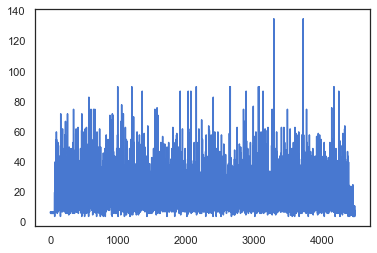


Value Counts for caption length top 5 values

Length|Counts
8     280
12    272
14    263
7     252
11    238
dtype: int64

The max and min value of "caption length" was found to be 135 and 4 respectively
The 80 percentile value of caption_len which is 28 will be taken as the maximum padded value for each impression


In [36]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '<unk>') #setting filters to none
tokenizer.fit_on_texts(train.impression_final.values)
train_captions = tokenizer.texts_to_sequences(train.impression_final) 
test_captions = tokenizer.texts_to_sequences(test.impression_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index['<cls>'] #tokened value of <cls>
end_index = tokenizer.word_index['<end>'] #tokened value of <end>

import matplotlib.pyplot as plt
#visualising impression length and other details
ax = plt.plot(caption_len)
#ax.set_titles('Value Counts vs Caption Length')
#ax.set_xlabels('Impresion length')
plt.show()
print('\nValue Counts for caption length top 5 values\n')
print('Length|Counts')
print(pd.Series(caption_len).value_counts()[:5])
print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 80 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression'%(np.percentile(caption_len,80)))
max_pad = int(np.percentile(caption_len,80))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader

Modelling 

Hyperparameter

In [37]:
batch_size = 100
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

In [38]:
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
  def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
    """
    df  = dataframe containing image_1,image_2 and impression
    """
    self.image1 = df.image_1
    self.image2 = df.image_2
    self.caption = df.impression_ip #inp
    self.caption1 = df.impression_op  #output
    self.input_size = input_size #tuple ex: (512,512)
    self.tokenizer = tokenizer
    self.augmentation = augmentation
    self.max_pad = max_pad

    #image augmentation
    #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
    self.aug1 = iaa.Fliplr(1) #flip images horizaontally
    self.aug2 = iaa.Flipud(1) #flip images vertically


  def __getitem__(self,i):
    #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image  and apply augmentation
    image1 = cv2.imread(self.image1[i],cv2.IMREAD_UNCHANGED)/255 
    image2 = cv2.imread(self.image2[i],cv2.IMREAD_UNCHANGED)/255 #here there are 3 channels
    image1 = cv2.resize(image1,self.input_size,interpolation = cv2.INTER_NEAREST)
    image2 = cv2.resize(image2,self.input_size,interpolation = cv2.INTER_NEAREST)
    if image1.any()==None:
      print("%i , %s image sent null value"%(i,self.image1[i]))
    if image2.any()==None:
      print("%i , %s image sent null value"%(i,self.image2[i]))


    #tokenizing and padding
    caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post') #opshape:(input_length,)
    caption = tf.squeeze(caption,axis=0) #opshape = (input_length,) removing unwanted axis if present

    caption1 = self.tokenizer.texts_to_sequences(self.caption1[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption1 = pad_sequences(caption1,maxlen = self.max_pad,padding = 'post') #opshape: (input_length,)
    caption1 = tf.squeeze(caption1,axis=0) #opshape = (input_length,) removing unwanted axis if present




    if self.augmentation: #we will not apply augmentation that crops the image 
          a = np.random.uniform()
          if a<0.333:
              image1 = self.aug1.augment_image(image1)
              image2 = self.aug1.augment_image(image2)
          elif a<0.667:
              image1 = self.aug2.augment_image(image1)
              image2 = self.aug2.augment_image(image2)
          else: #applying no augmentation
            pass;

    
    return image1,image2,caption,caption1

    
  def __len__(self):
    return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):     #for batching
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] #getting the shuffled index values
        data = [self.dataset[j] for j in indexes] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,image_2,caption)
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad


        return tuple([[batch[0],batch[1],batch[2]],batch[3]]) #here [image1,image2, caption(without <END>)],caption(without <CLS>) (op)
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self): #it runs at the end of epoch
        if self.shuffle:
            np.random.shuffle(self.indexes) #in-place shuffling takes place

In [39]:
input_size = (224,224)
train_dataloader = Dataset(train,input_size)
train_dataloader = Dataloader(train_dataloader,batch_size = batch_size)

test_dataloader = Dataset(test,input_size)
test_dataloader = Dataloader(test_dataloader,batch_size = batch_size)

In [40]:
#chexnet weights ; https://drive.google.com/file/d/19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b/view
def create_chexnet(chexnet_weights = chexnet_weights):
  """
  chexnet_weights: weights value in .h5 format of chexnet
  creates a chexnet model with preloaded weights present in chexnet_weights file
  """
  model = tf.keras.applications.DenseNet121(include_top=False) #importing densenet the last layer will be a relu activation layer

  #we need to load the weights so setting the architecture of the model as same as the one of tha chexnet
  x = model.output #output from chexnet
  x = GlobalAveragePooling2D()(x)
  x = Dense(14, activation="sigmoid", name="chexnet_output")(x) #here activation is sigmoid as seen in research paper

  chexnet = tf.keras.Model(inputs = model.input,outputs = x)
  chexnet.load_weights(chexnet_weights)
  chexnet = tf.keras.Model(inputs = model.input,outputs = chexnet.layers[-2].output)  #we will be taking the penultimate layer (second last layer here it is global avgpooling)
  return chexnet

In [41]:
chexnet = create_chexnet()
chexnet.trainable = False

tf.keras.utils.plot_model(
    chexnet,
    to_file="model_1.png",
    show_shapes=True,
)


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [42]:
del chexnet

In [43]:
    class Image_encoder(tf.keras.layers.Layer):
      """
      This layer will output image backbone features after passing it through chexnet
      here chexnet will be not be trainable
      """
      def __init__(self,
                   name = "image_encoder_block"
                   ):
        super().__init__()
        self.chexnet = create_chexnet()
        self.chexnet.trainable = False
        # for i in range(10): #the last 10 layers of chexnet will be trained
        #   self.chexnet.layers[-i].trainable = True

      def call(self,data):
        op = self.chexnet(data)
        return op

In [44]:
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

In [45]:
glove = {}
with open('glove.6B.300d.txt',encoding='utf-8') as f: #taking 300 dimesions
  for line in f:
    word = line.split() #it is stored as string like this "'the': '.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.4"
    glove[word[0]] = np.asarray(word[1:], dtype='float32')


embedding_dim = 300
# create a weight matrix for words in training docs for embedding purpose
embedding_matrix = np.zeros((vocab_size+1, embedding_dim)) #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

for word, i in tokenizer.word_index.items():
  embedding_vector = glove.get(word)
  if embedding_vector is not None: #if the word is found in glove vectors
      embedding_matrix[i] = embedding_vector[:embedding_dim]

DenseNet + LSTM

In [46]:
tf.keras.backend.clear_session()
image1 = Input(shape = (input_size + (3,))) #shape = 224,224,3
image2 = Input(shape = (input_size + (3,))) #https://www.w3resource.com/python-exercises/tuple/python-tuple-exercise-5.php
caption = Input(shape = (max_pad,))




img_encoder = Image_encoder() #contains chexnet model which is set trainable  =  False
# img2_encoder = Image_encoder() #opshape: (?,1024)
bk_feat1 = img_encoder(image1)
# bk_dense = Dense(dense_dim,
#                  activation = 'relu',
#                  name = 'bk_dense'
#                   )
# bk_feat1 = bk_dense(bk_feat1) #dense for the first image op: (?,dense_dim)

bk_feat2 = img_encoder(image2)
# bk_feat2 = bk_dense(bk_feat2) #dense for the 2nd image op: (?,dense_dim)

bk_features_concat = Concatenate(axis=-1)([bk_feat1,bk_feat2]) #concatenating the backbone images op_shape: (?,1024)
# bk_features_concat = BatchNormalization()(bk_features_concat) #applying batch norm
# bk_features_concat = Dropout(dropout_rate)(bk_features_concat) 
image_dense = Dense(dense_dim,
                    activation = 'relu',
                    name = 'Image_dense',
                    use_bias='False'

                    )

                    
image_bkbone = image_dense(bk_features_concat) #final op from dense op_shape: (?,dense_dim) this will be added as initial states to the lstm
image_dense_op = tf.keras.backend.expand_dims(image_bkbone,axis=1) #op_shape: (?,1,dense_dim)



embedding = Embedding(input_dim  = vocab_size+1,
                              output_dim = embedding_dim,
                              input_length = max_pad,
                              mask_zero = True,
                              weights = [embedding_matrix],
                              name = 'embedding'
                              )
embed_op = embedding(caption) #op_shape: (?,input_length,embedding_dim)






lstm_layer = LSTM(units = lstm_units,
                  return_sequences= True,
                  return_state = True     
                  )
lstm_op,lstm_h,lstm_c = lstm_layer(embed_op,initial_state = [image_bkbone,image_bkbone]) #op_shape = batch_size*input_length*lstm_units

# lstm_op = BatchNormalization()(lstm_op)
add = Add()([image_dense_op,lstm_op]) #op_shape: (?,input_lenght,lstm_units/dense_dim) here lstm_dims=dense_dim

op_dense = Dense(vocab_size+1,
                 activation = 'softmax',
                 name = 'output_dense'
                 ) #op: (?,input_length,vocab_size+1)

output = op_dense(add)

model = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)

In [47]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
image_encoder (Image_encoder)   (None, 1024)         7037504     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2048)         0           image_encoder[0][0]   

In [48]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy() 

def custom_loss(y_true, y_pred):
    #getting mask value to not consider those words which are not present in the true caption
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    #y_pred = y_pred+10**-7 #to prevent loss becoming null

    #calculating the loss
    loss_ = loss_func(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #returning mean over all the values
    return tf.reduce_mean(loss_)

lr = 10**-3
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)   
model.compile(optimizer=optimizer,loss=custom_loss,metrics= ['accuracy'])

In [50]:
tf.keras.backend.clear_session()
tb_filename = 'pickle_files/Simple_Encoder_Decoder/'
#tb_file = os.path.join('pickle_files',tb_filename)
model_filename = 'Simple_Encoder_Decoder.h5'
model_save = os.path.join('pickle_files/',model_filename)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5,
                                     verbose = 2
                                     ),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save,
                                       save_best_only = True,
                                      save_weights_only = True,
                                       verbose = 2
                                       ),
    tf.keras.callbacks.TensorBoard(histogram_freq=1,
                                   log_dir=tb_filename),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=10**-7, verbose = 2)
                                   
] #from keras documentation

In [53]:
model.fit(train_dataloader,
          validation_data = test_dataloader,
          epochs = 20
          )

Epoch 1/20
44/44 [==============================] - ETA: 0s - loss: 1.1782 - accuracy: 0.67 - ETA: 26s - loss: 1.1619 - accuracy: 0.685 - ETA: 38s - loss: 1.1423 - accuracy: 0.678 - ETA: 42s - loss: 1.1559 - accuracy: 0.683 - ETA: 44s - loss: 1.1363 - accuracy: 0.683 - ETA: 45s - loss: 1.1267 - accuracy: 0.683 - ETA: 46s - loss: 1.1233 - accuracy: 0.682 - ETA: 46s - loss: 1.1137 - accuracy: 0.684 - ETA: 45s - loss: 1.1116 - accuracy: 0.687 - ETA: 44s - loss: 1.1174 - accuracy: 0.688 - ETA: 43s - loss: 1.1261 - accuracy: 0.688 - ETA: 42s - loss: 1.1298 - accuracy: 0.688 - ETA: 42s - loss: 1.1233 - accuracy: 0.690 - ETA: 40s - loss: 1.1217 - accuracy: 0.691 - ETA: 39s - loss: 1.1135 - accuracy: 0.689 - ETA: 38s - loss: 1.1159 - accuracy: 0.690 - ETA: 37s - loss: 1.1165 - accuracy: 0.690 - ETA: 36s - loss: 1.1169 - accuracy: 0.690 - ETA: 34s - loss: 1.1127 - accuracy: 0.690 - ETA: 33s - loss: 1.1109 - accuracy: 0.690 - ETA: 32s - loss: 1.1147 - accuracy: 0.691 - ETA: 30s - loss: 1.1154 - 

Epoch 5/20
44/44 [==============================] - ETA: 0s - loss: 1.0474 - accuracy: 0.78 - ETA: 32s - loss: 1.0181 - accuracy: 0.777 - ETA: 41s - loss: 1.0309 - accuracy: 0.790 - ETA: 45s - loss: 1.0502 - accuracy: 0.786 - ETA: 46s - loss: 1.0238 - accuracy: 0.788 - ETA: 47s - loss: 1.0191 - accuracy: 0.787 - ETA: 47s - loss: 1.0072 - accuracy: 0.788 - ETA: 46s - loss: 0.9918 - accuracy: 0.786 - ETA: 46s - loss: 0.9979 - accuracy: 0.787 - ETA: 45s - loss: 1.0010 - accuracy: 0.786 - ETA: 44s - loss: 1.0036 - accuracy: 0.784 - ETA: 43s - loss: 0.9990 - accuracy: 0.785 - ETA: 42s - loss: 1.0025 - accuracy: 0.787 - ETA: 41s - loss: 0.9971 - accuracy: 0.786 - ETA: 40s - loss: 0.9973 - accuracy: 0.785 - ETA: 38s - loss: 0.9980 - accuracy: 0.784 - ETA: 37s - loss: 0.9954 - accuracy: 0.785 - ETA: 36s - loss: 0.9954 - accuracy: 0.785 - ETA: 35s - loss: 0.9887 - accuracy: 0.785 - ETA: 33s - loss: 0.9907 - accuracy: 0.786 - ETA: 32s - loss: 0.9908 - accuracy: 0.786 - ETA: 30s - loss: 0.9906 - 

Epoch 9/20
44/44 [==============================] - ETA: 0s - loss: 0.9439 - accuracy: 0.83 - ETA: 30s - loss: 0.9308 - accuracy: 0.841 - ETA: 39s - loss: 0.9243 - accuracy: 0.846 - ETA: 42s - loss: 0.9335 - accuracy: 0.853 - ETA: 45s - loss: 0.9397 - accuracy: 0.855 - ETA: 45s - loss: 0.9333 - accuracy: 0.853 - ETA: 46s - loss: 0.9297 - accuracy: 0.855 - ETA: 45s - loss: 0.9235 - accuracy: 0.853 - ETA: 45s - loss: 0.9276 - accuracy: 0.853 - ETA: 44s - loss: 0.9253 - accuracy: 0.851 - ETA: 43s - loss: 0.9227 - accuracy: 0.850 - ETA: 42s - loss: 0.9247 - accuracy: 0.850 - ETA: 41s - loss: 0.9240 - accuracy: 0.848 - ETA: 40s - loss: 0.9173 - accuracy: 0.847 - ETA: 39s - loss: 0.9181 - accuracy: 0.846 - ETA: 37s - loss: 0.9166 - accuracy: 0.846 - ETA: 36s - loss: 0.9155 - accuracy: 0.847 - ETA: 35s - loss: 0.9161 - accuracy: 0.847 - ETA: 34s - loss: 0.9141 - accuracy: 0.846 - ETA: 32s - loss: 0.9115 - accuracy: 0.844 - ETA: 31s - loss: 0.9135 - accuracy: 0.845 - ETA: 30s - loss: 0.9130 - 

Epoch 13/20
44/44 [==============================] - ETA: 0s - loss: 0.8965 - accuracy: 0.87 - ETA: 30s - loss: 0.8909 - accuracy: 0.879 - ETA: 39s - loss: 0.8880 - accuracy: 0.875 - ETA: 43s - loss: 0.8770 - accuracy: 0.876 - ETA: 44s - loss: 0.8699 - accuracy: 0.874 - ETA: 45s - loss: 0.8683 - accuracy: 0.871 - ETA: 45s - loss: 0.8712 - accuracy: 0.872 - ETA: 45s - loss: 0.8680 - accuracy: 0.869 - ETA: 44s - loss: 0.8635 - accuracy: 0.868 - ETA: 44s - loss: 0.8615 - accuracy: 0.867 - ETA: 43s - loss: 0.8614 - accuracy: 0.868 - ETA: 42s - loss: 0.8557 - accuracy: 0.867 - ETA: 41s - loss: 0.8581 - accuracy: 0.867 - ETA: 40s - loss: 0.8582 - accuracy: 0.867 - ETA: 39s - loss: 0.8567 - accuracy: 0.868 - ETA: 37s - loss: 0.8522 - accuracy: 0.867 - ETA: 36s - loss: 0.8553 - accuracy: 0.867 - ETA: 35s - loss: 0.8518 - accuracy: 0.866 - ETA: 34s - loss: 0.8519 - accuracy: 0.865 - ETA: 32s - loss: 0.8509 - accuracy: 0.866 - ETA: 31s - loss: 0.8515 - accuracy: 0.866 - ETA: 30s - loss: 0.8519 -

Epoch 17/20
44/44 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.86 - ETA: 29s - loss: 0.6950 - accuracy: 0.860 - ETA: 39s - loss: 0.7215 - accuracy: 0.868 - ETA: 42s - loss: 0.7450 - accuracy: 0.873 - ETA: 45s - loss: 0.7726 - accuracy: 0.876 - ETA: 46s - loss: 0.7774 - accuracy: 0.879 - ETA: 46s - loss: 0.7818 - accuracy: 0.880 - ETA: 45s - loss: 0.7833 - accuracy: 0.880 - ETA: 45s - loss: 0.7802 - accuracy: 0.881 - ETA: 44s - loss: 0.7767 - accuracy: 0.880 - ETA: 43s - loss: 0.7803 - accuracy: 0.879 - ETA: 42s - loss: 0.7802 - accuracy: 0.880 - ETA: 41s - loss: 0.7813 - accuracy: 0.879 - ETA: 40s - loss: 0.7796 - accuracy: 0.879 - ETA: 39s - loss: 0.7765 - accuracy: 0.879 - ETA: 38s - loss: 0.7790 - accuracy: 0.879 - ETA: 36s - loss: 0.7809 - accuracy: 0.878 - ETA: 35s - loss: 0.7820 - accuracy: 0.879 - ETA: 34s - loss: 0.7818 - accuracy: 0.879 - ETA: 33s - loss: 0.7826 - accuracy: 0.879 - ETA: 31s - loss: 0.7831 - accuracy: 0.879 - ETA: 30s - loss: 0.7846 -

In [54]:
model_filename = 'Simple_Encoder_Decoder.h5'
model_save = os.path.join('pickle_files',model_filename)
model1 = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)
model1.load_weights(model_save)

In [55]:
def get_bleu(reference,prediction):
  """
  Given a reference and prediction string, outputs the 1-gram,2-gram,3-gram and 4-gram bleu scores
  """
  reference = [reference.split()] #should be in an array (cos of multiple references can be there here only 1)
  prediction = prediction.split()
  bleu1 = sentence_bleu(reference,prediction,weights = (1,0,0,0),)
  bleu2 = sentence_bleu(reference,prediction,weights = (0.5,0.5,0,0))
  bleu3 = sentence_bleu(reference,prediction,weights = (0.33,0.33,0.33,0))
  bleu4 = sentence_bleu(reference,prediction,weights = (0.25,0.25,0.25,0.25))

  return bleu1,bleu2,bleu3,bleu4

In [56]:
#calculate bleu scores for every datapoint
def mean_bleu(test,predict,model=model1,**kwargs):
  """
  given a df and predict fucntion which predicts the impression of the caption
  outpus the mean bleu1,bleu2,bleu3, bleu4 for entire datapoints in df
  """
  if kwargs!=None:
    top_k = kwargs.get('top_k')
  else:
    top_k = None
  bleu1,bleu2,bleu3,bleu4 = [],[],[],[]
  for index,data in test.iterrows():
    if top_k==None:
      predict_val = predict(data['image_1'],data['image_2'],model = model) #predicted sentence
    else:
      predict_val = predict(data['image_1'],data['image_2'],model = model,top_k = top_k)
    true = data.impression
    _ = get_bleu(true,predict_val)
    bleu1.append(_[0])
    bleu2.append(_[1])
    bleu3.append(_[2])
    bleu4.append(_[3])
  return np.array(bleu1).mean(),np.array(bleu2).mean(),np.array(bleu3).mean(),np.array(bleu4).mean()

In [57]:
def greedy_search_predict(image1,image2,model = model1):
  """
  Given paths to two x-ray images predicts the impression part of the x-ray in a greedy search algorithm
  """
  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255 
  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  

  image1 = model.get_layer('image_encoder')(image1) #output from chexnet
  image2 = model.get_layer('image_encoder')(image2)

  # image1 = model.get_layer('bk_dense')(image1) #op from dense layer
  # image2 = model.get_layer('bk_dense')(image2)

  concat = model.get_layer('concatenate')([image1,image2])
  image_dense = model.get_layer('Image_dense')(concat)
  # concat = model.get_layer('batch_normalization')(concat)
  # image_dense = model.get_layer('Image_dense')(concat)
  bk_feat = tf.keras.backend.expand_dims(image_dense,axis=1)


  states = [image_dense, image_dense]
  a = []
  pred = []
  for i in range(max_pad):
    if i==0: #if first word
      caption = np.array(tokenizer.texts_to_sequences(['<cls>'])) #shape: (1,1)
    caption= model.get_layer('embedding')(caption) #embedding shape = 1*1*300
    caption,state_h,state_c = model.get_layer('lstm')(caption,initial_state = states) #lstm 1*1*512
    states = [state_h,state_c]

    add = model.get_layer('add')([bk_feat,caption]) #add
    output = model.get_layer('output_dense')(add) #1*1*vocab_size (here batch_size=1)

    #prediction
    max_prob = tf.argmax(output,axis=-1) #tf.Tensor of shape = (1,1)
    caption = np.array(max_prob) #will be sent to embedding for next iteration
    if max_prob==np.squeeze(tokenizer.texts_to_sequences(['<end>'])): 
      break;
    else:
      a.append(tf.squeeze(max_prob).numpy())
  return tokenizer.sequences_to_texts([a])[0] #here output would be 1,1 so subscripting to open the array

In [58]:
%%time
k=-1
image1,image2 = test['image_1'].iloc[k],test['image_2'].iloc[k]
print(greedy_search_predict(image1,image2,model=model))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

.
Wall time: 188 ms


In [59]:
%%time
_ = mean_bleu(test,greedy_search_predict)

Wall time: 1min 10s


In [60]:
k = list(_)
index = 'greedy search'
result = pd.DataFrame([k],columns = ["bleu1","bleu2","bleu3","bleu4"],index = [index])

# For CNN Encoder and LSTM Decoder

Attention CNN and LSTM

In [64]:
#image_folder = '/content/drive/My Drive/Medical image Reporting/Images'
folder_name = 'pickle_files'
tr_file_name = 'train.pkl'
te_file_name = 'test.pkl'
chexnet_weights = 'chexnet_weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

In [65]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, Conv2D,Activation, Dropout, Add, MaxPooling2D, GRU, AveragePooling2D, UpSampling2D, Multiply
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math

In [66]:
train = pd.read_pickle(os.path.join(folder_name,tr_file_name))
test = pd.read_pickle(os.path.join(folder_name,te_file_name))
train.shape,test.shape

((4487, 8), (563, 8))

In [67]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '<unk>') #setting filters to none
tokenizer.fit_on_texts(train.impression_final.values)
train_captions = tokenizer.texts_to_sequences(train.impression_final) 
test_captions = tokenizer.texts_to_sequences(test.impression_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index['<cls>'] #tokened value of <cls>
end_index = tokenizer.word_index['<end>'] #tokened value of <end>

print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 80 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression'%(np.percentile(caption_len,80)))
max_pad = int(np.percentile(caption_len,80))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader


The max and min value of "caption length" was found to be 135 and 4 respectively
The 80 percentile value of caption_len which is 28 will be taken as the maximum padded value for each impression


In [68]:
batch_size = 100
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

In [69]:
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
  def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
    """
    df  = dataframe containing image_1,image_2 and impression
    """
    self.image1 = df.image_1
    self.image2 = df.image_2
    self.caption = df.impression_ip #inp
    self.caption1 = df.impression_op  #output
    self.input_size = input_size #tuple ex: (512,512)
    self.tokenizer = tokenizer
    self.augmentation = augmentation
    self.max_pad = max_pad

    #image augmentation
    #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
    self.aug1 = iaa.Fliplr(1) #flip images horizaontally
    self.aug2 = iaa.Flipud(1) #flip images vertically

    # https://imgaug.readthedocs.io/en/latest/source/overview/convolutional.html?highlight=emboss#emboss
    self.aug3 = iaa.Emboss(alpha=(1), strength=1) #embosses image

    #https://imgaug.readthedocs.io/en/latest/source/api_augmenters_convolutional.html?highlight=sharpen#imgaug.augmenters.convolutional.Sharpen
    self.aug4 = iaa.Sharpen(alpha=(1.0), lightness=(1.5)) #sharpens the image and apply some lightness/brighteness 1 means fully sharpened etc

  def __getitem__(self,i):
    #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image  and apply augmentation
    image1 = cv2.imread(self.image1[i],cv2.IMREAD_UNCHANGED)/255 
    image2 = cv2.imread(self.image2[i],cv2.IMREAD_UNCHANGED)/255 #here there are 3 channels
    image1 = cv2.resize(image1,self.input_size,interpolation = cv2.INTER_NEAREST)
    image2 = cv2.resize(image2,self.input_size,interpolation = cv2.INTER_NEAREST)
    if image1.any()==None:
      print("%i , %s image sent null value"%(i,self.image1[i]))
    if image2.any()==None:
      print("%i , %s image sent null value"%(i,self.image2[i]))


    #tokenizing and padding
    caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post') #opshape:(input_length,)
    caption = tf.squeeze(caption,axis=0) #opshape = (input_length,) removing unwanted axis if present

    caption1 = self.tokenizer.texts_to_sequences(self.caption1[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption1 = pad_sequences(caption1,maxlen = self.max_pad,padding = 'post') #opshape: (input_length,)
    caption1 = tf.squeeze(caption1,axis=0) #opshape = (input_length,) removing unwanted axis if present




    if self.augmentation: #we will not apply augmentation that crops the image 
          a = np.random.uniform()
          if a<0.333:
              image1 = self.aug1.augment_image(image1)
              image2 = self.aug1.augment_image(image2)
          elif a<0.667:
              image1 = self.aug2.augment_image(image1)
              image2 = self.aug2.augment_image(image2)
          else: #applying no augmentation
            pass;

    
    return image1,image2,caption,caption1

    
  def __len__(self):
    return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):     #for batching
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] #getting the shuffled index values
        data = [self.dataset[j] for j in indexes] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,image_2,caption)
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad


        return tuple([[batch[0],batch[1],batch[2]],batch[3]]) #here [image1,image2, caption(without <END>)],caption(without <CLS>) (op)
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_batch_end(self): #it runs at the end of epoch
        if self.shuffle:
            np.random.shuffle(self.indexes) #in-place shuffling takes place

In [70]:
input_size = (224,224)
train_dataloader = Dataset(train,input_size)
train_dataloader = Dataloader(train_dataloader,batch_size = batch_size)

test_dataloader = Dataset(test,input_size)
test_dataloader = Dataloader(test_dataloader,batch_size = batch_size)

In [71]:
#chexnet weights ; https://drive.google.com/file/d/19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b/view
def create_chexnet(chexnet_weights = chexnet_weights,input_size = input_size):
  """
  chexnet_weights: weights value in .h5 format of chexnet
  creates a chexnet model with preloaded weights present in chexnet_weights file
  """
  model = tf.keras.applications.DenseNet121(include_top=False,input_shape = input_size+(3,)) #importing densenet the last layer will be a relu activation layer

  #we need to load the weights so setting the architecture of the model as same as the one of tha chexnet
  x = model.output #output from chexnet
  x = GlobalAveragePooling2D()(x)
  x = Dense(14, activation="sigmoid", name="chexnet_output")(x) #here activation is sigmoid as seen in research paper

  chexnet = tf.keras.Model(inputs = model.input,outputs = x)
  chexnet.load_weights(chexnet_weights)
  chexnet = tf.keras.Model(inputs = model.input,outputs = chexnet.layers[-3].output)  #we will be taking the 3rd last layer (here it is layer before global avgpooling)
  #since we are using attention here
  return chexnet

Attention Model

In [72]:
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

In [73]:
class Image_encoder(tf.keras.layers.Layer):
  """
  This layer will output image backbone features after passing it through chexnet
  here chexnet will be not be trainable
  """
  def __init__(self,
               name = "image_encoder_block"
               ):
    super().__init__()
    self.chexnet = create_chexnet()
    self.chexnet.trainable = False
    # for i in range(10): #the last 10 layers of chexnet will be trained
    #   self.chexnet.layers[-i].trainable = True
    
  def call(self,data):
    op = self.chexnet(data) #op shape: (None,7,7,1024)
    return op 

In [74]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, X ,name="global_flow"): #X = shape of the input
        super().__init__(name=name)
        self.matrix_shape = X[1:] #X.shape[1:]
        self.avgpooling = GlobalAveragePooling2D()
        self.bn = BatchNormalization()
        self.activation = Activation('relu')
        self.conv = Conv2D(
                    filters = self.matrix_shape[-1],
                    kernel_size = 1,
                    strides=1,
                    padding="same",
                    activation='relu'
                    )
        self.upsample = UpSampling2D(size=(self.matrix_shape[1], self.matrix_shape[1]),
                                     interpolation='bilinear')
        
    def call(self, X):
        # implement the global flow operatiom
        X = self.avgpooling(X) #shape: (batch size,1,no. of filters)
        X = tf.expand_dims(tf.expand_dims(X,1),1) #op shape = batch-size*1*1*number of filters
        X = self.bn(X)
        X = self.activation(X)
        X = self.conv(X) #op shape = None*1*1*number of filters
        
        #we need to get same shape as input to this layer
        X = self.upsample(X)
        
        return X

In [75]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, X,name="context_flow"): 
        super().__init__(name=name) #here X is shape of INP, FLOW = X[0], X[1] 
#         inp,flow = X[0], X[1] 
#         concat_ip = concatenate([inp,flow],axis=-1) #functional concatenate
#         self.matrix_shape = concat_ip.shape[1:]
        x,x1 = X[0],X[1]
        X = x[1],x[2],x[3]+x1[3]
        self.matrix_shape = X #X.shape[1:]
#         self.global_shape = flow.shape
        self.global_shape = x1[1:]
        self.concat = Concatenate(axis=-1)
        self.avgpooling = AveragePooling2D(pool_size=1,strides = self.matrix_shape[:2])
        self.bn = BatchNormalization()
        self.activation1 = Activation('relu')
        self.activation2 = Activation('relu')
        self.activation3 = Activation('sigmoid')
        self.conv1 = Conv2D(
                    filters = self.matrix_shape[-1],
                    kernel_size = 3,
                    strides=1,
                    padding="same",
                   activation = 'relu'
                    )
        self.conv2 = Conv2D(
                    filters = self.matrix_shape[-1],
                    kernel_size = 3,
                    strides=1,
                    padding="same",
                    activation = 'relu'
                    )
        self.conv3 = Conv2D(
                    filters = self.matrix_shape[-1],
                    kernel_size = 1,
                    strides=1,
                    padding="same",
                    activation='relu'
                    )
        self.conv4 = Conv2D(
                    filters = self.matrix_shape[-1],
                    kernel_size = 1,
                    strides=1,
                    padding="same",
                    activation='relu'
                    )
        self.multiply = Multiply()
        self.add = Add()
        self.upsample = tf.keras.layers.Conv2DTranspose( 
                            #here no. filters is equal to the no. of filters in output from global flow
                            filters = self.global_shape[-1], #output shape = (n-1)*s + k - 2*p here p=0,n=1,k=no. of filters in the input tensor
                            kernel_size = self.global_shape[:2],
                            strides=1,
                            padding="valid", 
                            activation='relu',
                            use_bias=False
                            )
        
    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        conc_op = self.concat([INP,FLOW])
        x = self.avgpooling(conc_op) #op_shape = batch_size*1*1*no. of filters
        # x = tf.expand_dims(tf.expand_dims(x,1),1)
        x = self.conv1(x)
        x = self.conv2(x)
        y = self.conv3(x)
        y = self.activation1(y)
        y = self.conv4(y)
        y = self.activation3(y)
        mult = self.multiply([y,x])
        add = self.add([mult,x])
        X = self.upsample(add) #shape = batch_size*inp_w*inp_h*inp
        return X #here context_flow and global_flow op willl have the same shape

# Encoder

In [76]:
def encoder(image1,image2,dense_dim = dense_dim,dropout_rate = dropout_rate):
  """
  Takes image1,image2
  gets the final encoded vector of these
  """
  #image1
  im_encoder = Image_encoder()
  
  bkfeat1 = im_encoder(image1) #shape: (None,49,1024)
  gf = global_flow(bkfeat1.shape)
  gf_op = gf(bkfeat1)
  cf = context_flow((bkfeat1.shape,gf_op.shape))
  cf_op = cf((bkfeat1,gf_op))
  bkfeat1 = Add()([gf_op,cf_op])

  #image2
  bkfeat2 = im_encoder(image2) #shape: (None,49,1024)
  gf_op2 = gf(bkfeat2)
  cf_op2 = cf((bkfeat2,gf_op2))
  bkfeat2 = Add()([gf_op2,cf_op2])  


  #combining image1 and image2
  
  concat = Concatenate(axis=-1)([bkfeat1,bkfeat2]) #concatenating through the second axis shape: (None,98,1024)
  concat = Dense(dense_dim,name = 'encoder_dense_final',activation = 'relu')(concat)
  op = tf.reshape(concat,(-1,concat.shape[1]*concat.shape[2],concat.shape[3]))
  bn = BatchNormalization(name = "encoder_batch_norm")(op) #(dense)#
  dropout = Dropout(dropout_rate,name = "encoder_dropout")(bn)
  return dropout

In [77]:
class global_attention(tf.keras.layers.Layer):
  """
  calculate global attention
  """
  def __init__(self,dense_dim = dense_dim):
    super().__init__()
    # Intialize variables needed for Concat score function here
    self.W1 = Dense(units = dense_dim) #weight matrix of shape enc_units*dense_dim
    self.W2 = Dense(units = dense_dim) #weight matrix of shape dec_units*dense_dim
    self.V = Dense(units = 1) #weight matrix of shape dense_dim*1 
      #op (None,98,1)


  def call(self,encoder_output,decoder_h): #here the encoded output will be the concatted image bk features shape: (None,98,dense_dim)
    decoder_h = tf.expand_dims(decoder_h,axis=1) #shape: (None,1,dense_dim)
    tanh_input = self.W1(encoder_output) + self.W2(decoder_h) #ouput_shape: batch_size*98*dense_dim
    tanh_output =  tf.nn.tanh(tanh_input)
    attention_weights = tf.nn.softmax(self.V(tanh_output),axis=1) #shape= batch_size*98*1 getting attention alphas
    op = attention_weights*encoder_output#op_shape: batch_size*98*dense_dim  multiply all aplhas with corresponding context vector
    context_vector = tf.reduce_sum(op,axis=1) #summing all context vector over the time period ie input length, output_shape: batch_size*dense_dim


    return context_vector,attention_weights


In [78]:
glove = {}
with open('glove.6B.300d.txt',encoding='utf-8') as f: #taking 300 dimesions
  for line in f:
    word = line.split() #it is stored as string like this "'the': '.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.4"
    glove[word[0]] = np.asarray(word[1:], dtype='float32')


embedding_dim = 300
# create a weight matrix for words in training docs for embedding purpose
embedding_matrix = np.zeros((vocab_size+1, embedding_dim)) #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

for word, i in tokenizer.word_index.items():
  embedding_vector = glove.get(word)
  if embedding_vector is not None: #if the word is found in glove vectors
      embedding_matrix[i] = embedding_vector[:embedding_dim]

In [79]:
class One_Step_Decoder(tf.keras.layers.Layer):
  """
  decodes a single token
  """
  def __init__(self,vocab_size = vocab_size, embedding_dim = embedding_dim, max_pad = max_pad, dense_dim = dense_dim ,name = "onestepdecoder"):
    # Initialize decoder embedding layer, LSTM and any other objects needed
    super().__init__()
    self.dense_dim = dense_dim
    self.embedding = Embedding(input_dim = vocab_size+1,
                                output_dim = embedding_dim,
                                input_length=max_pad,
                                weights = [embedding_matrix],
                                mask_zero=True, 
                                name = 'onestepdecoder_embedding'
                              )
    self.LSTM = GRU(units=self.dense_dim,
                    # return_sequences=True,
                    return_state=True,
                    name = 'onestepdecoder_LSTM'
                    )
    self.attention = global_attention(dense_dim = dense_dim)
    self.concat = Concatenate(axis=-1)
    self.dense = Dense(dense_dim,name = 'onestepdecoder_embedding_dense',activation = 'relu')
    self.final = Dense(vocab_size+1,activation='softmax')
    self.concat = Concatenate(axis=-1)
    self.add =Add()
  @tf.function
  def call(self,input_to_decoder, encoder_output, decoder_h):#,decoder_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B

      here state_h,state_c are decoder states
    '''
    embedding_op = self.embedding(input_to_decoder) #output shape = batch_size*1*embedding_shape (only 1 token)
    # embedding_op = self.dense(embedding_op)

    context_vector,attention_weights = self.attention(encoder_output,decoder_h) #passing hidden state h of decoder and encoder output
    #context_vector shape: batch_size*dense_dim we need to add time dimension
    context_vector_time_axis = tf.expand_dims(context_vector,axis=1)
    #now we will combine arrention output context vector with next word input to the lstm here we will be teacher forcing
    concat_input = self.concat([context_vector_time_axis,embedding_op])#output dimension = batch_size*input_length(here it is 1)*(dense_dim+embedding_dim)
    
    
    output,decoder_h = self.LSTM(concat_input,initial_state = decoder_h)
    #output shape = batch*1*dense_dim and decoder_h,decoder_c has shape = batch*dense_dim
    #we need to remove the time axis from this decoder_output
   

    output = self.final(output)#shape = batch_size*decoder vocab size
    return output,decoder_h,attention_weights #decoder_c,

# Decoder

In [80]:
class decoder(tf.keras.Model):
  """
  Decodes the encoder output and caption
  """
  def __init__(self,max_pad = max_pad, embedding_dim = embedding_dim,dense_dim = dense_dim,score_fun='general',batch_size = batch_size,vocab_size = vocab_size):
    super().__init__()
    self.onestepdecoder = One_Step_Decoder(vocab_size = vocab_size, embedding_dim = embedding_dim, max_pad = max_pad, dense_dim = dense_dim)
    self.output_array = tf.TensorArray(tf.float32,size=max_pad)
    self.max_pad = max_pad
    self.batch_size = batch_size
    self.dense_dim =dense_dim
    
  @tf.function
  def call(self,encoder_output,caption):#,decoder_h,decoder_c): #caption : (None,max_pad), encoder_output: (None,dense_dim)
    decoder_h, decoder_c = tf.zeros_like(encoder_output[:,0]), tf.zeros_like(encoder_output[:,0]) #decoder_h, decoder_c
    output_array = tf.TensorArray(tf.float32,size=max_pad)
    for timestep in range(self.max_pad): #iterating through all timesteps ie through max_pad
      # output,decoder_h,decoder_c,attention_weights = self.onestepdecoder(caption[:,timestep:timestep+1], encoder_output, decoder_h,decoder_c)
      output,decoder_h,attention_weights = self.onestepdecoder(caption[:,timestep:timestep+1], encoder_output, decoder_h)
      output_array = output_array.write(timestep,output) #timestep*batch_size*vocab_size

    self.output_array = tf.transpose(output_array.stack(),[1,0,2]) #.stack :Return the values in the TensorArray as a stacked Tensor.)
        #shape output_array: (batch_size,max_pad,vocab_size)
    return self.output_array

In [81]:
#model creation
tf.keras.backend.clear_session()
image1 = Input(shape = (input_size + (3,))) #shape = 224,224,3
image2 = Input(shape = (input_size + (3,))) #https://www.w3resource.com/python-exercises/tuple/python-tuple-exercise-5.php
caption = Input(shape = (max_pad,))

encoder_output = encoder(image1,image2) #shape: (None,28,512)

output = decoder()(encoder_output,caption)

model = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)

In [82]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
image_encoder (Image_encoder)   (None, 7, 7, 1024)   7037504     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_flow (global_flow)       (None, 7, 7, 1024)   1053696     image_encoder[0][0]   

In [83]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy() 

def custom_loss(y_true, y_pred):
    #getting mask value to not consider those words which are not present in the true caption
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    #y_pred = y_pred+10**-7 #to prevent loss becoming null

    #calculating the loss
    loss_ = loss_func(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #returning mean over all the values
    return tf.reduce_mean(loss_)

lr = 10**-2
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)   
model.compile(optimizer=optimizer,loss=custom_loss,metrics= ['accuracy'])

In [97]:
tf.keras.backend.clear_session()
tb_filename = 'pickle_files/Encoder_Decoder_global_attention_custom_model/'
#tb_file = os.path.join('pickle_files',tb_filename)
model_filename = 'Encoder_Decoder_global_attention_custom_model.h5'
model_save = os.path.join('pickle_files/',model_filename)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5,
                                     verbose = 2
                                     ),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save,
                                       save_best_only = True,
                                      save_weights_only = True,
                                       verbose = 2
                                       ),
    tf.keras.callbacks.TensorBoard(histogram_freq=1,
                                   log_dir=tb_filename),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=10**-7, verbose = 2)
                                   
] #from keras documentation

In [99]:
model.fit(train_dataloader,
          validation_data = train_dataloader,
          epochs = 2
          )

Epoch 1/2
44/44 [==============================] - ETA: 0s - loss: 0.3052 - accuracy: 0.92 - ETA: 15s - loss: 0.3018 - accuracy: 0.921 - ETA: 24s - loss: 0.3004 - accuracy: 0.921 - ETA: 28s - loss: 0.2581 - accuracy: 0.927 - ETA: 30s - loss: 0.2705 - accuracy: 0.926 - ETA: 31s - loss: 0.2712 - accuracy: 0.926 - ETA: 31s - loss: 0.2789 - accuracy: 0.925 - ETA: 31s - loss: 0.2829 - accuracy: 0.924 - ETA: 31s - loss: 0.2865 - accuracy: 0.923 - ETA: 30s - loss: 0.2988 - accuracy: 0.923 - ETA: 30s - loss: 0.2996 - accuracy: 0.922 - ETA: 29s - loss: 0.2998 - accuracy: 0.923 - ETA: 29s - loss: 0.2993 - accuracy: 0.922 - ETA: 28s - loss: 0.2981 - accuracy: 0.921 - ETA: 27s - loss: 0.2956 - accuracy: 0.921 - ETA: 26s - loss: 0.2942 - accuracy: 0.921 - ETA: 26s - loss: 0.2949 - accuracy: 0.922 - ETA: 25s - loss: 0.2945 - accuracy: 0.922 - ETA: 24s - loss: 0.2944 - accuracy: 0.922 - ETA: 23s - loss: 0.2925 - accuracy: 0.922 - ETA: 22s - loss: 0.2926 - accuracy: 0.922 - ETA: 21s - loss: 0.2904 - a

In [100]:
model_filename = 'Encoder_Decoder_global_attention_custom_model.h5'
model_save = os.path.join('pickle_shares',model_filename)
model1 = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)
model1.load_weights(model_save)

In [101]:
def get_bleu(reference,prediction):
  """
  Given a reference and prediction string, outputs the 1-gram,2-gram,3-gram and 4-gram bleu scores
  """
  reference = [reference.split()] #should be in an array (cos of multiple references can be there here only 1)
  prediction = prediction.split()
  bleu1 = sentence_bleu(reference,prediction,weights = (1,0,0,0),)
  bleu2 = sentence_bleu(reference,prediction,weights = (0.5,0.5,0,0))
  bleu3 = sentence_bleu(reference,prediction,weights = (0.33,0.33,0.33,0))
  bleu4 = sentence_bleu(reference,prediction,weights = (0.25,0.25,0.25,0.25))

  return bleu1,bleu2,bleu3,bleu4

In [102]:
#calculate bleu scores for every datapoint
def mean_bleu(test,predict,model=model1,**kwargs):
  """
  given a df and predict fucntion which predicts the impression of the caption
  outpus the mean bleu1,bleu2,bleu3, bleu4 for entire datapoints in df
  """
  if kwargs!=None:
    top_k = kwargs.get('top_k')
  else:
    top_k = None
  bleu1,bleu2,bleu3,bleu4 = [],[],[],[]
  for index,data in test.iterrows():
    if top_k==None:
      predict_val = predict(data['image_1'],data['image_2'],model = model) #predicted sentence
    else:
      predict_val = predict(data['image_1'],data['image_2'],model = model,top_k = top_k)
    true = data.impression
    _ = get_bleu(true,predict_val)
    bleu1.append(_[0])
    bleu2.append(_[1])
    bleu3.append(_[2])
    bleu4.append(_[3])
  return np.array(bleu1).mean(),np.array(bleu2).mean(),np.array(bleu3).mean(),np.array(bleu4).mean()

In [103]:
def encoder_op(image1,image2,model = model1):
  """
  Given image1 and image2 filepath, outputs
  their backbone features which will be input
  to the decoder
  """
  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255
  aug3 = iaa.Emboss(alpha=(1), strength=1) #embosses image
  aug4 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))
  image1 = aug4.augment_image(image1)
  image2 = aug4.augment_image(image2)
  image1 = aug3.augment_image(image1)
  image2 = aug3.augment_image(image2)
  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  
  image1 = model.get_layer('image_encoder')(image1) #output from chexnet
  image2 = model.get_layer('image_encoder')(image2)

  #global flow and context flow
  gf1 = model.get_layer('global_flow')(image1)
  cf1 = model.get_layer('context_flow')([image1,gf1])
  
  gf2 = model.get_layer('global_flow')(image1)
  cf2 = model.get_layer('context_flow')([image1,gf1])

  image1 = model.get_layer('add_1')([gf1,cf1])
  image2 = model.get_layer('add_2')([gf2,cf2])
  concat = model.get_layer('concatenate_1')([image1,image2])
  enc_op = model.get_layer('encoder_dense_final')(concat)
  enc_op = tf.reshape(enc_op,(-1,enc_op.shape[1]*enc_op.shape[2],enc_op.shape[3]))
  enc_op = model.get_layer('encoder_batch_norm')(enc_op) 
  enc_op = model.get_layer('encoder_dropout')(enc_op) #this is the output from encoder

  return enc_op

In [104]:
def greedy_search_predict(image1,image2,model = model1):
  """
  Given paths to two x-ray images predicts the impression part of the x-ray in a greedy search algorithm
  """
  enc_op = encoder_op(image1,image2) #this is the output from encoder


  decoder_h,decoder_c = tf.zeros_like(enc_op[:,0]),tf.zeros_like(enc_op[:,0])
  a = []
  pred = []
  for i in range(max_pad):
    if i==0: #if first word
      caption = np.array(tokenizer.texts_to_sequences(['<cls>'])) #shape: (1,1)
    output,decoder_h,attention_weights = model.get_layer('decoder').onestepdecoder(caption,enc_op,decoder_h)#,decoder_c) decoder_c,

    #prediction
    max_prob = tf.argmax(output,axis=-1)  #tf.Tensor of shape = (1,1)
    caption = np.array([max_prob]) #will be sent to onstepdecoder for next iteration
    if max_prob==np.squeeze(tokenizer.texts_to_sequences(['<end>'])): 
      break;
    else:
      a.append(tf.squeeze(max_prob).numpy())
  return tokenizer.sequences_to_texts([a])[0] #here output would be 1,1 so subscripting to open the array

In [105]:
%%time
k = -1
image1,image2 = test.image_1.iloc[k],test.image_2.iloc[k]
print(greedy_search_predict(image1,image2,model1))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

no acute abnormality . no pulmonary nodule identified .
Wall time: 446 ms


In [106]:
%%time
_ = mean_bleu(test,greedy_search_predict)

Wall time: 1min 8s


In [107]:
k = list(_)
index = 'greedy search'
result = pd.DataFrame([k],columns = ["bleu1","bleu2","bleu3","bleu4"],index = [index])
result

,bleu1,bleu2,bleu3,bleu4
greedy search,0.214358,0.109067,0.005529,0.002247


In [108]:
def beam_search_predict(image1,image2,top_k=3,max_pad = max_pad,model = model1):
  """
  Given image1, image2 get the top
  beam search predicted sentence
  """
  k = top_k
  cls_token = tokenizer.texts_to_sequences(['<cls>'])[0] #[3]
  enc_op = encoder_op(image1,image2)
  states = tf.zeros_like(enc_op[:,0]) #state_h only
  seq_score = [[cls_token,0,states]] #[[[3], 0]]
  finished_seq_score = []
  for i in range(max_pad): #traverse through all lengths
    all_candidates = [] #stores all the top k seq along with their scores
    new_seq_score = [] #stores the seq_score which does not have <end> in them
    for s in seq_score: #traverse for all top k sequences
      text_input = s[0][-1] #getting the last predicted output
      states = s[2]
      caption = np.array([[text_input]]) #ip must be in shape (batch_size,seq length,dim)
      output,states,attention_weights =  model.get_layer('decoder').onestepdecoder(caption,enc_op,states) #here output has shape (1,vocab_size)
      top_words = tf.argsort(output[0],direction = 'DESCENDING')[:k] #get the top k words

      seq,score,_ = s
      for t in top_words.numpy():
        #here we will update score with log of probabilities and subtracting(log of prob will be in negative)
        #here since its -(log), lower the score higher the prob
        candidates = [seq+[t],score-np.log(output[0][t].numpy()),states] #updating the score and seq
        all_candidates.append(candidates)
      seq_score = sorted(all_candidates,key = lambda l:l[1])[:k] #getting the top 3 sentences with high prob ie low score
      #checks for  <end> in each seq obtained
      count = 0
      end_token = tokenizer.word_index['<end>']
      for seq,score,state in seq_score:
        # print('seq,score',seq,score)
        if seq[-1] == end_token: #if last word of the seq is <end>
          finished_seq_score.append([seq,score])
          count+=1
        else:
          new_seq_score.append([seq,score,state])
      k-=count #substracting the no. of finished sentences from beam length
      seq_score = new_seq_score

      if seq_score==[]: #if null array
        break;
      else:
        continue;

  seq_score = finished_seq_score[-1]
  sentence = seq_score[0][1:-1] #here <cls> and <end> is here so not considering that
  score = seq_score[1]
      
  return tokenizer.sequences_to_texts([sentence])[0]

In [109]:
%%time
k = -1
image1,image2 = test.image_1.iloc[k],test.image_2.iloc[k]
print(beam_search_predict(image1,image2))

no acute abnormality . no pulmonary nodule identified .
Wall time: 2.95 s


In [110]:
%%time
test['bleu_1_gs'] = np.zeros(test.shape[0]) #greedy search
test['prediction_gs'] = np.zeros(test.shape[0]) #greedy search

for index,rows in test.iterrows():
  #greedy search
  predicted_text = greedy_search_predict(rows.image_1,rows.image_2,model1)
  test.loc[index,'prediction_gs'] = predicted_text
  reference = [rows['impression'].split()]
  test.loc[index,'bleu_1_gs'] = sentence_bleu(reference,predicted_text.split(),weights = (1,0,0,0))

Wall time: 1min 9s


In [111]:
test['prediction_gs'].value_counts()*100/test.shape[0] #greedy search

no acute abnormality . no pulmonary nodule identified .    100.0
Name: prediction_gs, dtype: float64

In [112]:
def final_caption_pred(image1,image2,method = "beam",top_k = 3,model=model1):
  """
  Given image1. image2 paths, the model, top_k and the method of prediction returns the predicted caption
  method: "greedy" or "g" for greedy search, "beam" or "b" for beam search
  """
  if method in ['greedy','g']:
    pred_caption = greedy_search_predict(image1,image2,model)
  elif method in ['beam','b']:
    pred_caption = beam_search_predict(image1,image2,top_k = top_k,model = model)
  else:
    print("Enter 'b' or 'beam' for beam search and 'g' or 'greedy' for greedy search")
  
  return pred_caption

In [113]:
def inference(image1,image2,true_caption,model=model1,top_k = None,image_size = (10,20)):
  """
  given 2 images (their paths), the true caption, the model and the range of top_k
  prints the two images, true caption along with greedy search prediction and beam search prediction of top_k range
  """
  image1_array = cv2.imread(image1,cv2.IMREAD_UNCHANGED)
  image2_array = cv2.imread(image2,cv2.IMREAD_UNCHANGED)
  if type(top_k)==int:
    top_k = [top_k] #changing it to list if top_k given is of int type
  greedy_caption = final_caption_pred(image1,image2,method='g',model=model) #getting the greedy search prediction

  #printing the 2 images
  plt.figure(figsize = image_size)
  plt.subplot(121)
  plt.imshow(image1_array)
  plt.axis("off")

  plt.subplot(122)
  plt.imshow(image2_array)
  plt.axis("off")
  plt.show()

  print("\nTrue caption: '%s'"%(true_caption))
  print("Predicted caption(greedy search): '%s'"%(greedy_caption))
  #beam search of top_k
  if top_k != None:
    for i in top_k:
      beam_caption = final_caption_pred(image1,image2,method='b',model=model,top_k = i)
      print("Predicted caption(beam search = %i): '%s'"%(i,beam_caption))


1 )


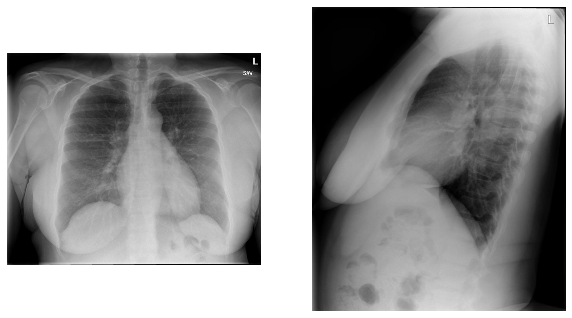


True caption: 'no acute cardiopulmonary abnormality . .'
Predicted caption(greedy search): 'no acute abnormality . no pulmonary nodule identified .'


2 )


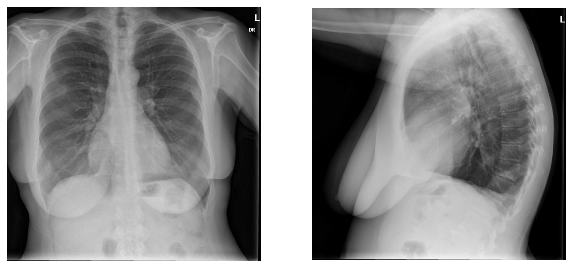


True caption: 'no acute cardiopulmonary abnormality . .'
Predicted caption(greedy search): 'no acute abnormality . no pulmonary nodule identified .'


3 )


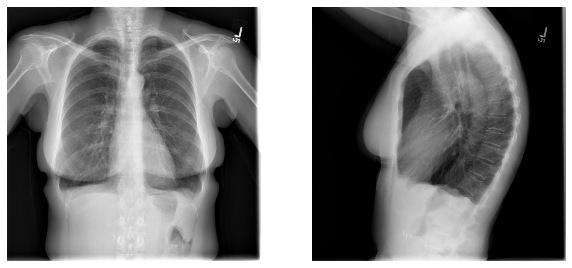


True caption: 'hyperinflated lungs . no acute cardiopulmonary abnormality .'
Predicted caption(greedy search): 'no acute abnormality . no pulmonary nodule identified .'


4 )


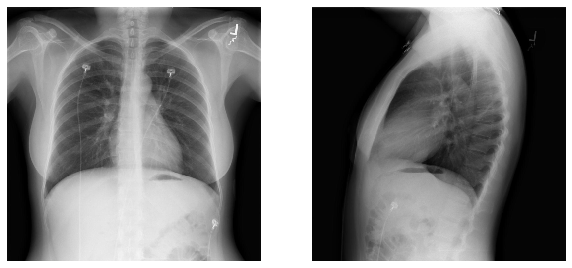


True caption: 'no acute cardiopulmonary abnormality identified .'
Predicted caption(greedy search): 'no acute abnormality . no pulmonary nodule identified .'


5 )


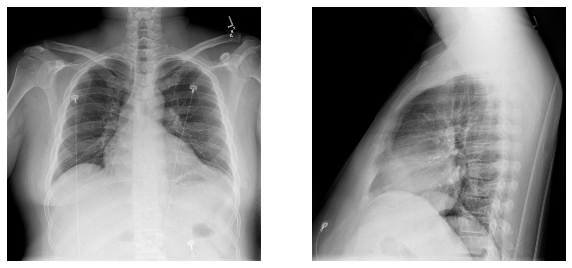


True caption: 'no acute pulmonary abnormality .'
Predicted caption(greedy search): 'no acute abnormality . no pulmonary nodule identified .'




In [114]:
i = test[test['bleu_1_gs']>0.5].sample(5).index
for j,k in enumerate(i):
  print(j+1,")")
  image1,image2 = test['image_1'][k],test['image_2'][k]
  true_caption = test['impression'][k]
  inference(image1,image2,true_caption)
  print("\n")

1 )


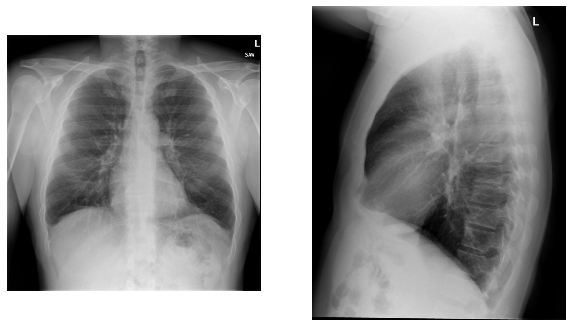


True caption: 'heart size is normal lungs are clear . no nodular masses . ct scan is more sensitive in detecting small nodules .'
Predicted caption(greedy search): 'no acute abnormality . no pulmonary nodule identified .'


2 )


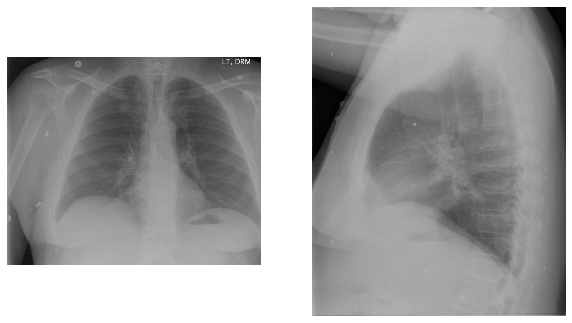


True caption: 'no focal lung opacity pleural effusion of pneumothorax . .'
Predicted caption(greedy search): 'no acute abnormality . no pulmonary nodule identified .'


3 )


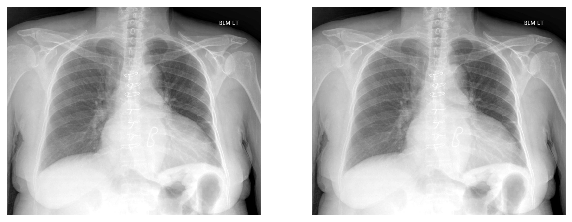


True caption: 'scarring in the left midlung . cardiomegaly with especially enlarged left atrium with postoperative changes of mitral valve surgery .'
Predicted caption(greedy search): 'no acute abnormality . no pulmonary nodule identified .'


4 )


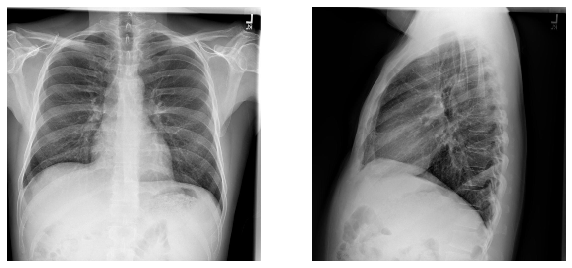


True caption: 'no evidence of active disease .'
Predicted caption(greedy search): 'no acute abnormality . no pulmonary nodule identified .'


5 )


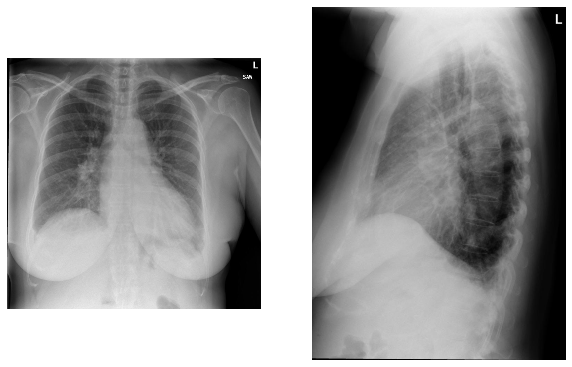


True caption: 'minimal cardiomegaly . prominent pulmonary probable very small pleural effusions and minimal questionable interstitial edema . no pneumonia'
Predicted caption(greedy search): 'no acute abnormality . no pulmonary nodule identified .'




In [115]:
i = test[test['bleu_1_gs']<=0.3].sample(5).index
for j,k in enumerate(i):
  print(j+1,")")
  image1,image2 = test['image_1'][k],test['image_2'][k]
  true_caption = test['impression'][k]
  inference(image1,image2,true_caption)
  print("\n")